***Considerations about tracking***

This notebook presents only first effects of analysing topic mentioned below. The workflow will be expanded in the future.

# Multi-Object Tracking Using Dynamical Graph Matching

This workflow is based on article with the same title. Actually, the approach is a bit diferent because I skip ML part and I use graph methods instead. All algorithms missing in the article was made based on graph methods as far as possible. I've tried to substitute function founded in the Internet by those made by my own.

Why dynamical graph matching? 
Object may enter/exit the scene, interaction can occur => number of nodes changes dynamically.

In [1]:
import numpy as np
import cv2
import glob
from PIL import Image
from scipy.ndimage.measurements import label
import two_cc 
import matplotlib.pyplot as plt
import math
from random import random, randint

For the first time getting frams from movie is necessary.

In [2]:
# # Getting frames from movie
# vidcap = cv2.VideoCapture('Capt2.mp4')
# success,image = vidcap.read()
# count = 0
# frames=[]
# while success:
#     cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file  
#     success,image = vidcap.read()
#     count += 1

First of all, let's upload frames of chosen movie.

In [3]:
frames=[]
for image in glob.glob("./frames/*.jpg"):
    image=Image.open(image)
    w, h = image.size
    image=image.crop((0, 250, 500, h-50))
    frames.append(image)

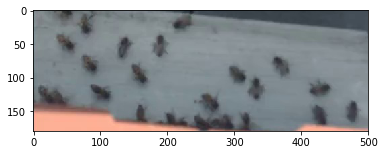

In [4]:
plt.imshow(frames[0])

If needed, we can also convert all frames into grayscale.

In [5]:
gray_frames=[]
for frame in frames:
    gray_frame=frame.convert('L')
    gray_frames.append(gray_frame)

### 1. Foreground separation and bounding boxes extraction

#### a) Foreground/background separation

##### I. From article - left just to show approach from article

In [6]:
# N=10 # parameter - number of image frames to background training. On this N frames there is no object undertaking significant movements in the scene

In [7]:
# # training stage - MACHINE LEARNING - add ?????
# def get_intensities(frames, N): #iterative formula to compute intensity mean and variance for each pixel
#     shape=frames[0].size
#     for i in range(shape[0]):
#         for j in range(shape[1]):
#             mean[0][i][j]=frames[0][i][j]
#             variance[0][i][j]=0
#     for f in range(1,N):
#         for i in range(shape[0]):
#             for j in range(shape[1]):
#                 mean[f][i][j]=mean[f-1][i][j]+(frames[f][i][j]-mean[f-1][i][j])/f
#                 variance[f][i][j]=(f-2)*(variance[f-1][i][j])/(f-1)+(frames[f][i][j]-mean[f-1][i][j])**2/f
#     return mean, variance

In [8]:
# # It is preferable that the system can adapt to the illumination change automatically
# # We periodically update the background statistics for pixels outside the bounding boxes (those are background pixels)
# def update_intensities(blocks,frame): # # Is proceeded after getting intensities
#     shape=frame.size
#     for index,block in blocks.enumerated():
#         if block==0: # It is not part of any box
#             for i in range(8*index[0],min(shape[0]-8*index[0], 8*index[0]+8)):
#                 for j in range(8*index[1],min(shape[1]-8*index[1], 8*index[1]+8)):
#                     mean[f][i][j]=mean[f-1][i][j]+(frames[f][i][j]-mean[f][i][j])/N
#                     variance[f][i][j]=variance[f-1][i][j]+(frames[f][i][j]**2-mean[f][i][j]**2)/(N-1)-N*(mean[f][i][j]**2-mean[f-1][i][j]**2)/(N-1)-variance[f][i][j]/N 

In [9]:
# def get_foreground_pixels(frame,thresh, mean, variance): #we obtain foreground pixels by comparing them to the computed values of mean and variance
#     for i in range(frame.size[0]):
#         for j in range(frame.size[1]):
#             if abs(frame[i][j]-mean[i][j])>thresh*sqrt(variance[i][j]):
#                 foreground[i][j]=1
#             else:
#                 foreground[i][j]=0
#     return foreground          

In [10]:
# def eliminate_singlepixel_noise(foreground):
#     one iteration of erosion
#     return support_map

##### II. Using algorithm for two-connected components

Two-connected components algorithm not only shows connected components but with all additional option gives us more separated objects.

In [11]:
work_map=[]
for i in range(5):
    work_map.append(two_cc.two_connected_components(frames[i],channel="red",thresh=86))

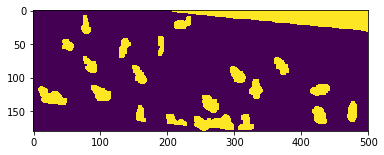

In [12]:
plt.imshow(work_map[0])

Let's note small changes in the two-connected components algorithm available on github:

In [13]:
# def get_result_array(channel, two_connected_components):    
#     result=np.zeros((channel.shape[0], channel.shape[1]))
#     for comp in two_connected_components:
#         for node in comp:
#             result[node[0],node[1]]=1    
#     return result

# def two_connected_components(img, channel = "all", fill_in = True, thresh = None):
#     image_arr = preparing_image(img, img.size)    
#     binary = converting_to_binary(image_arr, channel, fill_in, thresh)
#     comps_smaller = get_components(binary)
#     return get_result_array(image_arr,comps_smaller)

#### b) Blocks construction

In [14]:
def construct_blocks(support_map): #our support map is divided into 8x8 blocks
    sms=support_map.shape
    width=math.ceil(sms[0]/8)
    height=math.ceil(sms[1]/8)
    blocks=np.zeros( (width, height) )
    for i in range(width):
        for j in range(height):
            # now for each box let's check if it contains more than 10 foreground pixels
            fore_pixels=0
            for k in range(min(8,sms[0]-8*i)): # on the border we can have less than 8 pixels in width/height
                for l in range(min(8,sms[1]-8*j)):
                    if support_map[8*i+k][8*j+l]==1:
                        fore_pixels+=1
            if fore_pixels>10:
                blocks[i][j]=1
    return blocks

In [15]:
blocks=[]
for i in range(5):
    blocks.append(construct_blocks(work_map[i]))

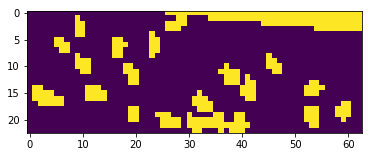

In [16]:
plt.imshow(blocks[0])

We will use algorithm based on DFS to find "connected" boxes. We will assign different integer number to all of them. This approach also gives as possibility to count elements of each components. This will be useful in the future.

In [17]:
# First version:
nums=0 

def dfs(array,box,i,j,index,nums,indices):
    nums+=1
    if i-1 > 0 and array[i-1][j]==1.0 and box[i-1][j]==0.0:
            box[i-1][j]=index
            indices[index].append((i-1,j))
            nums=dfs(array,box,i-1,j,index,nums,indices)
    if j-1 > 0 and array[i][j-1]==1.0 and box[i][j-1]==0.0:
            box[i][j-1]=index
            indices[index].append((i,j-1))
            nums=dfs(array,box,i,j-1,index,nums,indices)
    if i+1 < array.shape[0] and array[i+1][j]==1.0 and box[i+1][j]==0.0:
            box[i+1][j]=index
            indices[index].append((i+1,j))
            nums=dfs(array,box,i+1,j,index,nums,indices)
    if j+1 < array.shape[1] and array[i][j+1]==1.0 and box[i][j+1]==0.0:
            box[i][j+1]=index
            indices[index].append((i,j+1))
            nums=dfs(array,box,i,j+1,index,nums,indices)
    return nums
            
def connected_blocks(array):
    counts=dict()
    indices=dict()
    nums=0
    index=1
    indices[index]=[]
    box=np.zeros(array.shape)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j]==1.0 and box[i][j]==0.0:
                box[i][j]=index
                indices[index].append((i,j))
                nums=dfs(array,box,i,j,index,nums,indices)
                counts[index]=nums
                index+=1
                indices[index]=[]
                nums=0
    return box,counts, indices

In [18]:
boxes=[]
count_boxes=[]
list_boxes=[]
for i in range(5):
    array, counts, indices = connected_blocks(blocks[i])
    boxes.append(array)
    count_boxes.append(counts)
    list_boxes.append(indices)
    

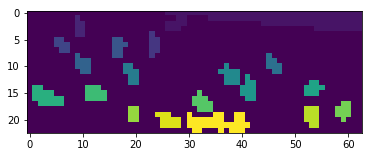

In [19]:
plt.imshow(boxes[0])

In [20]:
print(count_boxes[0])

{1: 103, 2: 7, 3: 8, 4: 7, 5: 9, 6: 9, 7: 8, 8: 9, 9: 11, 10: 11, 11: 9, 12: 17, 13: 11, 14: 11, 15: 9, 16: 6, 17: 11, 18: 11, 19: 32}


In [21]:
list_boxes[0][3]

[(4, 23), (5, 23), (6, 23), (7, 23), (8, 23), (7, 24), (6, 24), (5, 24)]

In [22]:
# # Second version:

# # https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html
# joined_blocks=[]

# for i in range(5):
#     joined_block, num_boxes = label(blocks[i])
#     joined_blocks.append(joined_block)

We will eliminate bounding boxes which consits of less than 5 blocks since we don't want to track really small objects.

In [23]:
# def eliminate_small_boxes(boxes): 
#     #Max=np.amax(array)
#     for k in range(5):
#         unique, counts = np.unique(boxes[k], return_counts=True)
#         small=[]
#         for key, value in dict(zip(unique, counts)):
#             if value<5:
#                 small+=key
#         for i in range(array.shape[0]):
#             for j in range(array.shape[1]):
#                 if boxes[k][i][j] in small:
#                     boxes[k][i][j]=0   
#     return boxes

In [24]:
def eliminate_small_boxes(boxes, counts): 
    small=[]
    for i in range (1, len(counts)+1):
        if counts[i]<5:
            small.append(i)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if boxes[i][j] in small:
                boxes[i][j]=0   
    return boxes

In [25]:
reduced_boxes=[]
#reduced_joined_blocks=[]
for i in range(5):
    reduced_boxes.append(eliminate_small_boxes(boxes[i],count_boxes[i]))
    #reduced_joined_blocks.append(eliminate_small_boxes(joined_blocks))

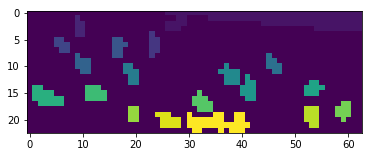

In [26]:
plt.imshow(reduced_boxes[0])

#### c) Visualization of bounding boxes

In [27]:
colors=[]
reduced_boxes_2=[]
random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
for i in range(5):
    reduced_boxes_2.append(np.array(reduced_boxes[i], dtype='int16'))
    colors.append([random_color() for i in range(np.amax(reduced_boxes_2[i])+1)])


In [28]:
def see_boxes(frame,boxes,colors):
    shape=frame.size
    frame_array = np.zeros((shape[1],shape[0],3), dtype='int16')
    for index,block in np.ndenumerate(boxes):
        if block > 0: 
            for i in range(8*index[0], min(shape[1], 8*index[0]+8)):
                for j in range(8*index[1], min(shape[0], 8*index[1]+8)):
                    frame_array[i][j]=colors[block]
    return frame_array

def see_boxes_on_frame(frame,boxes):
    shape=frame.size
    frame_array = np.array(frame, dtype='int16')
    for index,pixel in np.ndenumerate(boxes):
        if pixel>0: 
            frame_array[index]=pixel
    return frame_array

In [29]:
def see_borders(frame,boxes,colors):
    shape=frame.size
    frame_array = np.zeros((shape[1],shape[0],3), dtype='int16')
    for index,block in np.ndenumerate(boxes):
        if block > 0:
            if (index[0]>0 and boxes[index[0]-1][index[1]]!=block):
                for j in range(8*index[1], min(shape[0], 8*index[1]+8)):
                    frame_array[8*index[0]][j]=colors[block]
            if (index[0]<boxes.shape[0]-1 and boxes[index[0]+1][index[1]]!=block):
                for j in range(8*index[1], min(shape[0], 8*index[1]+8)):
                    frame_array[min(shape[1], 8*index[0]+8)-1][j]=colors[block]
            if (index[1]>0 and boxes[index[0]][index[1]-1]!=block):
                for i in range(8*index[0], min(shape[1], 8*index[0]+8)):
                    frame_array[i][8*index[1]]=colors[block]
            if (index[1]<boxes.shape[1]-1 and boxes[index[0]][index[1]+1]!=block):
                for i in range(8*index[0], min(shape[1], 8*index[0]+8)):
                    frame_array[i][min(shape[0], 8*index[1]+8)-1]=colors[block]
    return frame_array

def see_borders_on_frame(frame,boxes):
    shape=frame.size
    frame_array = np.array(frame, dtype='int16')
    for index,pixel in np.ndenumerate(boxes):
        if pixel>0: 
            frame_array[index]=pixel
    return frame_array

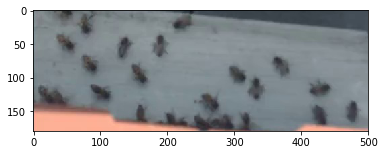

In [30]:
plt.imshow(frames[0])

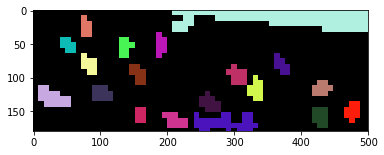

In [31]:
img2=see_boxes(frames[0],reduced_boxes_2[0],colors[0])
plt.imshow(img2)

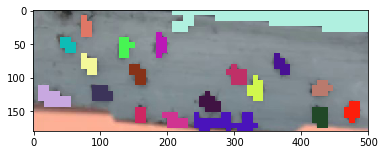

In [32]:
img3=see_boxes_on_frame(frames[0],img2)
plt.imshow(img3)

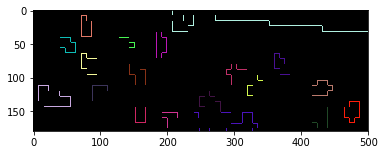

In [33]:
img4=see_borders(frames[0],reduced_boxes_2[0],colors[0])
plt.imshow(img4)

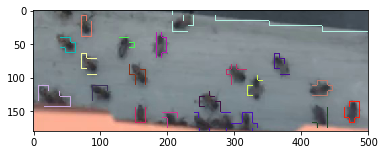

In [34]:
img5=see_borders_on_frame(frames[0],img4)
plt.imshow(img5)

In [35]:
reduced_boxes_2[0]

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

Why some edges are missing?

### 2. Creating Dynamical Graph Matching - first attempt

#### a) Preparing nodes

Each object is represented by a probability distribution of intensity values via histogrm analysis.

There is an issue that our object will have similar intensity distribution.

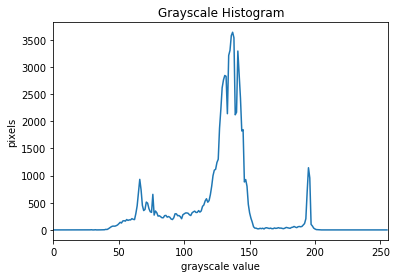

In [36]:
def histogram(gray):
    gray=np.array(gray,dtype='int16')
    intens = [0]*256
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            intens[gray[i][j]]+=1
    return intens

im_hist=histogram(gray_frames[0])

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0, 256])

plt.plot(im_hist)
plt.show()

The intensity space is divided into n bins. Function named "bin_assignment" is defined uniquely by pixel's intensity.

In [37]:
boxes_list = []
boxes[0]=np.array(reduced_boxes[0], dtype='int16')
for i in range(int(np.amax(boxes[0])+1)):
    boxes_list.append(set())
for index, pixel in np.ndenumerate(boxes[0]):
        boxes_list[int(pixel)].add(index)

In [38]:
# n=len(boxes_list)
# print(n)
n=20

In [39]:
def bin_assignment(frame, n):
    b=np.array(frame,dtype='int16')
    for index, pixel in np.ndenumerate(frame):
        b[index]=math.floor(pixel/n)+1 #value between 1 and n, defined by pixel's intensity
    return b

bin_assign=bin_assignment(gray_frames[0],n)

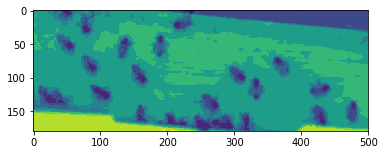

In [40]:
plt.imshow(bin_assign)

In [ ]:
def probability(bin_assign,u, box): #u is a number of bin, we count probability that box (object) is "in" u'th bin
    value=0
    number=0
    for pixel in box: #this loop is not gonna work
        if bin_assign[pixel]==u:
            value+=1
        number+=1
    return value/number

def box_probability_distribution(bin_assign, box,n):
    p_box=[0]
    for u in range(1,n+1):
        p_box.append(probability(bin_assign,u,box))
    return p_box
        
def probability_distribution(frame,boxes,bin_assign,n):
    object_probability=[]
    for box in boxes:
        object_probability.append(box_probability_distribution(bin_assign,box,n))
    return object_probability

object_probability=probability_distribution(gray_frames[0],boxes_list,bin_assign,n)
        

In [42]:
for i in range(20):
    print(object_probability[i])

[0, 0.0, 0.0, 0.02608695652173913, 0.04, 0.09913043478260869, 0.23043478260869565, 0.5791304347826087, 0.025217391304347827, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0.0, 0.0, 0.3300970873786408, 0.10679611650485436, 0.2621359223300971, 0.2621359223300971, 0.038834951456310676, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8571428571428571, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [43]:
def check(n, object_probability):
    for list_of_probab in object_probability:
        sum_of_probab=0
        for u in range(1,n+1):
            sum_of_probab+=list_of_probab[u]
        if sum_of_probab!=1:
            return False
    return True

print(check(n, object_probability))

True


#### b) Conclusions

##### As we can see, our detected object have similar intensity probabilities so we cannot match them based on them.

The numbers of nodes of both types are kept the same.

Profile nodes: nodes from previous frame
    
Object nodes: nodes from current frame
    
The matching cost/dissimilarity between a profile node and an object node is measured by the Kullback-Leibler distance.

D(p(u),q(u))= sum of u from 1 to n of p(u) multiplied by log of p(u)/q(u) 

where p(u) - intensity probabiloty of the profile node
q(u) - intensity probability of the object node

##### The distance will be the same for more than one pair of nodes - we will not be able to track bees.

In [44]:
from networkx.algorithms.bipartite import matching

### 3. Creating Dynamical Graph Matching - second attempt

Number of bins = number of blocks. Each block is a bin. From now we are working on map of blocks. 

For each bin we count distance from each box. This time we base on distance not intensity.

For i'th box and bin u we are computing p(u) as sum of distances between bin and blocks in boxes divided by (diameter multiplied by - ?) number of blocks in the box.

In [138]:
def distance_from_box(index):
    p_block=[0]
    for u in range(1, len(list_boxes[0])):
        value=0
        for pixel in list_boxes[0][u]:
            value+=math.sqrt((index[0]-pixel[0])**2+(index[1]-pixel[1])**2)
        p_block.append(value/count_boxes[0][u]) #mean distance from box
    return p_block

def distances_from_boxes(frame_number):       
    object_distances={}
    for index,block in np.ndenumerate(blocks[frame_number]):
        object_distances[index]=distance_from_box(index)
    return object_distances

object_distances_0=distances_from_boxes(0)
object_distances_1=distances_from_boxes(1)

Now we compute mean distance between boxes.

In [139]:
object_distances_0[(17,45)]

[0,
 19.229685765473956,
 38.344070577328516,
 24.287385040590245,
 40.52680919183114,
 30.253900037581477,
 35.77040843996178,
 7.35259416250994,
 26.496192222013217,
 9.019619432262694,
 4.807436944752175,
 8.847323516689013,
 41.85102004630428,
 32.70148227000829,
 12.581270461924232,
 14.20589101242124,
 25.591293163053606,
 8.488574167235639,
 19.1805225546678,
 10.405130101332098]

In [144]:
from operator import add

def boxes_distances(frame_number, object_distances):
    boxes_distances={}
    for box_index in range(1, len(list_boxes[frame_number])):
        boxes_distances[box_index]=[0 for i in range(1,len(list_boxes[frame_number]))]
        for index in list_boxes[frame_number][box_index]:
    #         boxes_distances[box_index]=list(map(add, boxes_distances[box_index], object_distances[index]))/count_boxes[0][box_index]
            boxes_distances[box_index]=[boxes_distances[box_index][i]+object_distances[index][i+1]/count_boxes[frame_number][box_index]\
                                        for i in range(len(list_boxes[frame_number])-1)]  
    return boxes_distances
boxes_distances_0=boxes_distances(0,object_distances_0)
boxes_distances_1=boxes_distances(1, object_distances_1)

In [146]:
boxes_distances_0[6]

[37.7157555396045,
 7.039793781324627,
 13.95687743459574,
 5.496869660244269,
 7.542430168179311,
 1.546344086521181,
 35.90052125946491,
 9.376072919762365,
 27.834723569486272,
 31.555428774258143,
 43.57667588493376,
 9.389598272802365,
 6.036795043620012,
 23.594806642152445,
 49.88693413566672,
 13.35209095741613,
 44.18869454879367,
 19.198769793081233,
 27.685089025929745]

In [147]:
diameter=math.sqrt(blocks[0].shape[0]**2+blocks[0].shape[1]**2)
sum(boxes_distances_0[6])/diameter

6.185955297405464

In [172]:
boxes_distances_0_array=boxes_distances_0[1]
for i in range(2, len(list_boxes[0])):
    boxes_distances_0_array=np.row_stack([boxes_distances_0_array,boxes_distances_0[i] ])

In [173]:
boxes_distances_0[1]

[12.68666501579257,
 37.217471138015,
 24.025296733001625,
 40.92326138083657,
 30.52694119717934,
 37.715755539604515,
 13.53414735886244,
 29.79492677327783,
 17.061661512677695,
 17.726826729833068,
 17.516638601643844,
 46.03541699488113,
 37.308681613001184,
 23.159284909330772,
 23.058889667592023,
 33.227746658501566,
 21.843357586359364,
 29.239981386835304,
 24.87297987730487]

In [174]:
boxes_distances_0_array

array([[12.68666502, 37.21747114, 24.02529673, 40.92326138, 30.5269412 ,
        37.71575554, 13.53414736, 29.79492677, 17.06166151, 17.72682673,
        17.5166386 , 46.03541699, 37.30868161, 23.15928491, 23.05888967,
        33.22774666, 21.84335759, 29.23998139, 24.87297988],
       [37.21747114,  1.38536936, 14.4118572 ,  4.91785059,  8.2545963 ,
         7.03979378, 37.14273299, 13.07741906, 29.72745893, 33.82432856,
        45.37732606, 14.64262507, 12.77013277, 27.02658462, 52.09764662,
        19.16741229, 46.74876478, 24.09863377, 31.58997826],
       [24.02529673, 14.4118572 ,  1.58606589, 17.43502402,  6.91506516,
        13.95687743, 22.85939829,  7.05063192, 15.51901543, 19.69951388,
        31.0699646 , 22.53151486, 14.3483117 , 14.17181998, 37.83492558,
        13.58791138, 32.61663365, 14.40724513, 19.11004839],
       [40.92326138,  4.91785059, 17.43502402,  1.31665226, 10.75555894,
         5.49686966, 40.06805114, 14.23670776, 32.26021353, 36.16692229,
        48.034

We've created an array with distances between boxes. Indices are pair of boxes.

This matrix is symmetric. Distance between i'th box and j'th is the same as distance between j'th and i'th boxes.

In [175]:
boxes_distances_0_array_transpose=np.transpose(boxes_distances_0_array)

In [180]:
(np.around(boxes_distances_0_array,decimals=5)==np.around(boxes_distances_0_array_transpose,decimals=5)).all()

True

We've rounded our results to get proper results. Some estimations could be made during computation.

In [181]:
boxes_distances_1_array=boxes_distances_1[1]
for i in range(2, len(list_boxes[1])):
    boxes_distances_1_array=np.row_stack([boxes_distances_1_array,boxes_distances_1[i] ])

Numbers on the main diagonal of the matrix are not equal to 0 because of irregular shapes of boxes.

In [184]:
np.diagonal(boxes_distances_0_array)

array([12.68666502,  1.38536936,  1.58606589,  1.31665226,  1.55849795,
        1.54634409,  1.51576619,  1.59390482,  1.706422  ,  1.74906174,
        1.49647335,  2.3343221 ,  1.66887323,  1.70225777,  1.49647335,
        1.17383279,  1.66887323,  1.81288627,  4.30591513])